In [18]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


BATCH_SIZE = 32

In [19]:
transform = transforms.Compose([
    transforms.Resize((int(300), int(300))),
    transforms.ToTensor()
])

data = datasets.ImageFolder(
    root='../input/children-vs-adults-images/train',
    transform=transform
)

train_idx, valid_idx = train_test_split(list(range(len(data))), train_size=0.9)

dataset = {
    'train': torch.utils.data.Subset(data, train_idx),
    'val': torch.utils.data.Subset(data, valid_idx)
}

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    ),
}

transform = transforms.Compose([
    transforms.Resize((int(300), int(300))),
    transforms.ToTensor()
])

dataset_test = datasets.ImageFolder(
    root="../input/children-vs-adults-images/test",
    transform=transform
)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=BATCH_SIZE)

datasets_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = np.array(data.classes)



In [20]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    '''

    main training code

    '''
    start = time.time()
    
    use_gpu = torch.cuda.is_available()
  
    best_mode_wts = model.state_dict()
    best_accuracy = 0.0

    losses = {'train': [], 'val': []}
    accuracy = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloader[phase], leave=False, desc=f'{phase} iter'):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels
        
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / datasets_sizes[phase]
            epoch_accuracy = curr_corrects / datasets_sizes[phase]

            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_accuracy)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_accuracy))

    model.load_state_dict(best_model_wts)
    
    return model, losses, accuracy

def evaluate(model):
    '''

    count accuracy on a test set

    '''

    model.eval()

    curr_correct = 0
    for data in dataloader['val']:
        inputs, labels = data

    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

    output = model(inputs)
    _, preds = torch.max(output, 1)

    curr_correct += int(torch.sum(preds == labels))

    return curr_correct / datasets_sizes['val']

def predict(model, dataloader_test, class_names):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloader_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    probs = np.argmax(probs, axis=1)
    probs = class_names[probs]
    return probs

In [21]:
model_efficientnet = models.efficientnet_b3(pretrained=True)

for param in model_efficientnet.parameters():
    param.require_grad = False

model_efficientnet.classifier    
model_efficientnet.classifier = nn.Sequential(nn.Dropout(p=0.3),
                                              nn.Linear(1536, len(data.classes))
                                             )

model_efficientnet = model_efficientnet.cuda()

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model_efficientnet.parameters()), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_efficientnet, losses_efficientnet, accs_efficientnet = train_model(model_efficientnet, loss_func, optimizer, exp_lr_scheduler, epochs=12)

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

train iter:   0%|          | 0/20 [00:00<?, ?it/s]

val iter:   0%|          | 0/3 [00:00<?, ?it/s]

Training complete in 2m 3s
Best val Acc: 0.9265


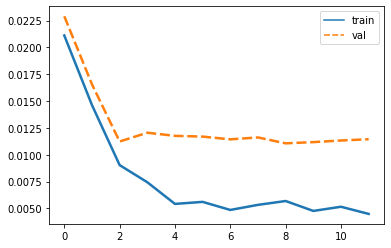

In [26]:
sns.lineplot(data=losses_efficientnet, palette="tab10", linewidth=2.5)
plt.show()

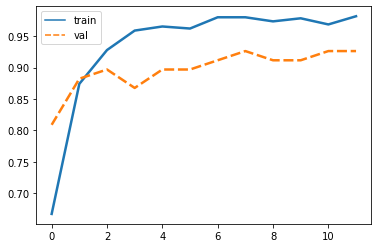

In [27]:
sns.lineplot(data=accs_efficientnet, palette="tab10", linewidth=2.5)
plt.show()

In [28]:
import pickle

with open('model_efficientnet_b3.pickle', 'wb') as f:
    pickle.dump(model_efficientnet, f)